In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import datetime


# Configuration file

In [2]:
MAX_LENGTH_OF_STAY = 60
MIN_LENGTH_OF_STAY = 8

SAVE_DATA = True
SAVE_DATA_AS = f'../data/EWS_0122-0423_scrubbed_O{MIN_LENGTH_OF_STAY}U{MAX_LENGTH_OF_STAY}.csv'
SAVE_DATA_AS


'../data/EWS_0122-0423_scrubbed_O8U60.csv'

In [3]:
def get_len_mean_var(df, column_name):
    #Group the DataFrame by the column you are interested in and count the rows in each group
    grouped = df.groupby(column_name).size()

    #Calculate the mean and standard deviation of the number of rows
    mean_count = grouped.mean()
    std_count = grouped.std()
    num_patients = len(df[column_name].unique())
    return num_patients, round(mean_count,1), round(std_count, 1)


## Load dataset

In [4]:
df_orig = pd.read_csv('../data/EWS_0122-0423_preprocessed.csv').sort_values('PatientID')
df_orig

,Index,PatientID,WardID,Timestamp,Systolic,Diastolic,O2,Pulse,Temp,Rf,Gender,Consciousness,AirOrO2,EwsScore,EwsType,WardName
240227,240227,185092,106.0,1667396849000,128.0,75.0,99.0,106.0,36.5,16.0,NaN,Våken,Luft,1,1,Akuttenhet Salten Bodø
225155,225155,185092,106.0,1667396849000,128.0,75.0,99.0,106.0,36.5,16.0,M,Våken,Luft,1,1,Akuttenhet Salten Bodø
278792,278792,191533,108.0,1649705464000,146.0,92.0,95.0,69.0,36.9,20.0,NaN,Våken,Luft,1,1,Observasjonspost Bodø
278612,278612,191533,108.0,1649676144000,120.0,67.0,97.0,58.0,36.3,14.0,NaN,Våken,Luft,0,1,Observasjonspost Bodø
263891,263891,191533,108.0,1649676144000,120.0,67.0,97.0,58.0,36.3,14.0,M,Våken,Luft,0,1,Observasjonspost Bodø
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288187,288187,2967437,108.0,1682624327000,146.0,110.0,96.0,76.0,36.5,16.0,None,Våken,Luft,0,1,Observasjonspost Bodø
288212,288212,2967439,108.0,1682632104000,144.0,83.0,96.0,70.0,36.5,16.0,None,Våken,Luft,0,1,Observasjonspost Bodø
288225,288225,2967522,83.0,1682643698000,122.0,54.0,95.0,88.0,37.1,18.0,None,Våken,Luft,1,1,Med enh. nyre-ford-inf Bodø
288227,288227,2967617,83.0,1682645131000,146.0,67.0,91.0,82.0,36.7,14.0,None,Våken,Luft,3,1,Med enh. nyre-ford-inf Bodø


## Removing duplicated rows, min amount of datapoints, split patients with over 48h between datapoints

In [5]:
df_scrubb = df_orig.drop_duplicates(subset=df_orig.columns.difference(['Index']), inplace=False)
print('Original Data')
print(f'Number of patients in dataset: {len(df_orig.PatientID.unique())}, rows in original dataset: {len(df_orig)}')

# sort the non duplicated data-frame
df_scrubb = df_scrubb.sort_values(['PatientID', 'Timestamp'])
df_scrubb.Index = np.arange(0,len(df_scrubb))
df_scrubb.set_index(np.arange(0,len(df_scrubb)), inplace=True)


stats = get_len_mean_var(df_orig, "PatientID")
print(f'Stats for of dataset, Patients: {stats[0]}, Mean datapoints: {stats[1]} and Standard deviation datapoints: {stats[2]}')

print('\nDuplicated rows')
print(f'Number of duplicated rows: {len(df_orig)-len(df_scrubb)}. That is {round(100-len(df_scrubb)/len(df_orig)*100, 2)}% of the dataset rows.')
stats = get_len_mean_var(df_scrubb, "PatientID")
print(f'Stats for of dataset, Patients: {stats[0]}, Mean datapoints: {stats[1]} and Standard deviation datapoints: {stats[2]}')

df_orig.sort_values('Gender')
print("Removing duplicated rows, ignoring gender - assume gender don't change during stay")
print(f"Gender distribution before:\n {df_scrubb.drop_duplicates(subset=['PatientID', 'Gender'])['Gender'].value_counts()}")
df_scrubb = df_orig.sort_values('Gender').drop_duplicates(subset=df_orig.columns.difference(['Index', 'Gender']), keep='first', inplace=False).sort_values('Index')
print(f'Number of duplicated rows: {len(df_orig)-len(df_scrubb)}. That is {round(100-len(df_scrubb)/len(df_orig)*100, 2)}% of the dataset rows.')
print(f"Gender distribution after:\n {df_scrubb.drop_duplicates(subset=['PatientID', 'Gender'])['Gender'].value_counts()}")
stats = get_len_mean_var(df_scrubb, "PatientID")
print(f'Stats for of dataset, Patients: {stats[0]}, Mean datapoints: {stats[1]} and Standard deviation datapoints: {stats[2]}')
df_orig_no_dup = df_scrubb.copy()

# remove patients with less than MIN_LENGTH_OF_STAY amount of timesteps
val_count = df_scrubb.PatientID.value_counts()
df_scrubb = df_scrubb[df_scrubb.PatientID.isin(val_count[val_count >= MIN_LENGTH_OF_STAY].index)]
print(f"\nRemoving patients with few datapoints (under {MIN_LENGTH_OF_STAY} datapoints). ")
print(f'Number of rows from patients with under {MIN_LENGTH_OF_STAY} datapoints: {sum(val_count[val_count < MIN_LENGTH_OF_STAY])}. That is {round(sum(val_count[val_count < MIN_LENGTH_OF_STAY])/len(df_orig)*100, 2)}% of the dataset rows.')
stats = get_len_mean_var(df_scrubb, "PatientID")
print(f'Stats for of dataset, Patients: {stats[0]}, Mean datapoints: {stats[1]} and Standard deviation datapoints: {stats[2]}')

# check for patients with multiple obeservations on the same timestep
double_data = []
for patID in df_scrubb.PatientID.unique():
    df_patID = df_scrubb[df_scrubb.PatientID==patID].copy()
    if len(df_patID) != len(df_patID.Timestamp.unique()):
        double_data.append(df_patID.PatientID.iloc[0])
to_remove = df_scrubb[df_scrubb.PatientID.isin(double_data)]
# checked manually that all duplicates manually, first notation had 1 value that differed, looking like a typo. 
# removing first of duplicated values.
to_remove = to_remove[to_remove.duplicated(subset=['Timestamp'], keep='first')]
df_scrubb.drop(to_remove.Index, inplace=True)
print(f'Found {len(to_remove)} paris of with the same patient ID and timestamp, removing outlier from each pair from the dataset.')
 ### Splitting patients with mutiple visits and checking for constant gender.
# split patients that have multiple visits
min_hours_to_split = 48
# df = df[df.Index<2000]
i=0
j=0
result = pd.DataFrame()

# set all None like value to 'None' for Gender feature
df_scrubb.Gender = df_scrubb.Gender.astype('str')
df_scrubb.loc[df_scrubb.Gender=='nan', 'Gender'] = 'None'
df_scrubb.loc[df_scrubb.Gender=='U', 'Gender'] = 'None'

print(f"Gender distribution before:\n {df_scrubb.drop_duplicates(subset=['PatientID', 'Gender'])['Gender'].value_counts()}")
print(f'\nLooping through {len(df_scrubb.PatientID.unique())} patients...')
print(f"Splitting patients with more than {min_hours_to_split} hours between data points.")
for patID in tqdm(df_scrubb.PatientID.unique()):
    df_patID = df_scrubb[df_scrubb.PatientID==patID].copy()
    
    # checking for change in gender during the stay, set genter to the value that is not None
    if len(df_scrubb[df_scrubb.PatientID==patID].Gender.unique())>1:
        mask = df_scrubb[df_scrubb.PatientID==patID].Gender.unique() != 'None'
        df_scrubb.loc[df_scrubb.PatientID==patID,'Gender'] =df_scrubb[df_scrubb.PatientID==patID].Gender.unique()[mask][0] 

    # checking for patients with split in datapoints time.
    time_in = min(df_patID.Timestamp)
    time_in_care = (df_patID['Timestamp'] - time_in) / (1000 * 3600)
    df_patID[df_patID.columns[df_patID.columns.get_loc('Timestamp')]] = time_in_care
    df_patID['Difference'] = df_patID['Timestamp'].diff()

    df_scrubb.loc[df_patID.Index, 'Time_in_care'] = time_in_care
    
    if any(df_patID[df_patID['Difference'].notna()]['Difference'].abs() > min_hours_to_split):
        i+=1
        pat_to_split = df_patID[df_patID['Difference'].abs() > min_hours_to_split]
        for k in range(len(pat_to_split)):
            j+=1
            # split patients that has long gaps between datapoints, PatientID + 10 000 000.
            df_scrubb.loc[(df_scrubb.PatientID == pat_to_split.PatientID.iloc[k]) & (df_scrubb.Index < pat_to_split.Index.iloc[k]), 'PatientID'] += 10000000*(k+1)

        result = pd.concat([result, pat_to_split])
print(f"Gender distribution after:\n {df_scrubb.drop_duplicates(subset=['PatientID', 'Gender'])['Gender'].value_counts()}")


val_count = df_scrubb.PatientID.value_counts()
print(f'\nFound {i} amount of patients with gap longer than {min_hours_to_split} hours in their stay. Splitting them into different PatientID, {j} new patients.')
stats = get_len_mean_var(df_scrubb, "PatientID")
print(f'Stats for of dataset, Patients: {stats[0]}, Mean datapoints: {stats[1]} and Standard deviation  datapoints: {stats[2]}')

print(f"\nFound {len(val_count[val_count < MIN_LENGTH_OF_STAY])} amount of short stays (under {MIN_LENGTH_OF_STAY} datapoints) after splitting, removing them. " 
      f"That is {round(sum(val_count[val_count < MIN_LENGTH_OF_STAY])/len(df_orig)*100, 2)}% of the dataset rows.")
df_scrubb = df_scrubb[df_scrubb.PatientID.isin(val_count[val_count >= MIN_LENGTH_OF_STAY].index)] # remove splits with less than MIN_LENGTH_OF_STAY datapoints. 
stats = get_len_mean_var(df_scrubb, "PatientID")
print(f'Stats for of dataset, Patients: {stats[0]}, Mean datapoints: {stats[1]} and Standard deviation  datapoints: {stats[2]}')


Original Data
Number of patients in dataset: 22024, rows in original dataset: 369653
Stats for of dataset, Patients: 22024, Mean datapoints: 16.8 and Standard deviation datapoints: 26.4

Duplicated rows
Number of duplicated rows: 38429. That is 10.4% of the dataset rows.
Stats for of dataset, Patients: 22024, Mean datapoints: 15.0 and Standard deviation datapoints: 23.3
Removing duplicated rows, ignoring gender - assume gender don't change during stay
Gender distribution before:
 M       8284
F       7952
None    6057
U        106
Name: Gender, dtype: int64
Number of duplicated rows: 180993. That is 48.96% of the dataset rows.
Gender distribution after:
 M       8284
F       7952
None    5880
U        106
Name: Gender, dtype: int64
Stats for of dataset, Patients: 22024, Mean datapoints: 8.6 and Standard deviation datapoints: 12.7

Removing patients with few datapoints (under 8 datapoints). 
Number of rows from patients with under 8 datapoints: 46612. That is 12.61% of the dataset rows.

100%|██████████| 7353/7353 [00:20<00:00, 356.21it/s]

Gender distribution after:
 M       6170
F       5508
None    3327
Name: Gender, dtype: int64

Found 3448 amount of patients with gap longer than 48 hours in their stay. Splitting them into different PatientID, 7652 new patients.
Stats for of dataset, Patients: 15005, Mean datapoints: 9.5 and Standard deviation  datapoints: 8.5

Found 7183 amount of short stays (under 8 datapoints) after splitting, removing them. That is 7.13% of the dataset rows.
Stats for of dataset, Patients: 7822, Mean datapoints: 14.8 and Standard deviation  datapoints: 8.7


In [6]:
print(5986/(8284+7952+5986))
print(3327/(6170+5508+3327))

print(8284/(8284+7952))
print(6170/(6170+5508))

df_scrubb.drop_duplicates(subset=['PatientID', 'Gender'])['Gender'].value_counts()[0]

0.2693726937269373
0.22172609130289903
0.5102241931510224
0.5283438945024833


3101

### Change ward ID to combinde wards with similar patients.


In [7]:
# Mapping based on info from Ståle Nymo: (NB: TOOK INTO CONSIDERATION ADDED INFO FROM MAIL
# 1: Psychiatry: 106, 105, 107, 70, 72
# 2: Medicine: 84, 83, 110, 64, 65, 85
# 3: Surgical AND Ortopedics (75): 67, 91, 114, 92, 75
# 5: Neurology: 79
# 6: ICU: 96, 82
# 7: Obst / Gyn: 97, 117
# 8: Observation unit: 108
# 9: Unknown

def getWard(w):
    if w == 106 or w == 105 or w == 107 or w == 72 or w == 70:
        return 1
    elif w == 83 or w == 84 or w == 85 or w == 64 or w == 65 or w == 110:
        return 2
    elif w == 67 or w == 91 or w == 92 or w == 114 or w == 75:
        return 3
    elif w == 79:
        return 5
    elif w == 96 or w == 82:
        return 6
    elif w == 97 or w == 117:
       return 7
    elif w == 108:
        return 8
    else:
        return 9

df_scrubb['WardID'] = df_scrubb['WardID'].apply(getWard)
print('Unique Ward ID and counts',np.unique(df_scrubb.WardID, return_counts=True))
df_scrubb

Unique Ward ID and counts (array([1, 2, 3, 5, 6, 8, 9], dtype=int64), array([  286, 50422, 51297,  9343,   614,  3495,   220], dtype=int64))


,Index,PatientID,WardID,Timestamp,Systolic,Diastolic,O2,Pulse,Temp,Rf,Gender,Consciousness,AirOrO2,EwsScore,EwsType,WardName,Time_in_care
10,10,12660707,2,1674705720000,120.0,66.0,94.0,113.0,39.5,28.0,None,Våken,Oksygen,10,1,Med enh. lunge-hem-kreft Bodø,94.385833
11,11,2639196,2,1674705834000,150.0,76.0,94.0,60.0,36.1,20.0,None,Våken,Luft,1,1,Med enh. lunge-hem-kreft Bodø,225.693889
15,15,12589700,2,1674706350000,113.0,55.0,90.0,82.0,36.1,16.0,F,Våken,Luft,3,1,Med enh. lunge-hem-kreft Bodø,745.720833
17,17,12644157,2,1674706607000,146.0,98.0,98.0,70.0,36.1,18.0,None,Våken,Luft,0,1,Med enh. lunge-hem-kreft Bodø,203.143889
18,18,12635003,2,1674706721000,189.0,98.0,92.0,68.0,36.1,14.0,None,Våken,Luft,2,1,Med enh. nyre-ford-inf Bodø,224.416111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369633,369633,2770753,3,1677278490000,99.0,52.0,90.0,92.0,38.2,28.0,None,Våken,Luft,10,1,Kir Gastro/Gyn/Brystendo Bodø,16.686389
369640,369640,2774474,3,1677281225000,120.0,70.0,92.0,89.0,36.4,18.0,None,Våken,Oksygen,4,1,Kirurgisk post Vesterålen,0.000000
369642,369642,2774180,3,1677282465000,85.0,50.0,94.0,58.0,36.9,17.0,None,Våken,Luft,4,1,Kirurgisk post Vesterålen,5.942222
369644,369644,2774118,3,1677287035000,128.0,62.0,93.0,99.0,36.6,20.0,None,Våken,Luft,3,1,Kir Gastro/Gyn/Brystendo Bodø,4.430556


# Stats for original Data-set

Amount of patients: 22024
Amount less or equal than 8: 14671
Amount more than 8: 7353
Amount more than 60: 250


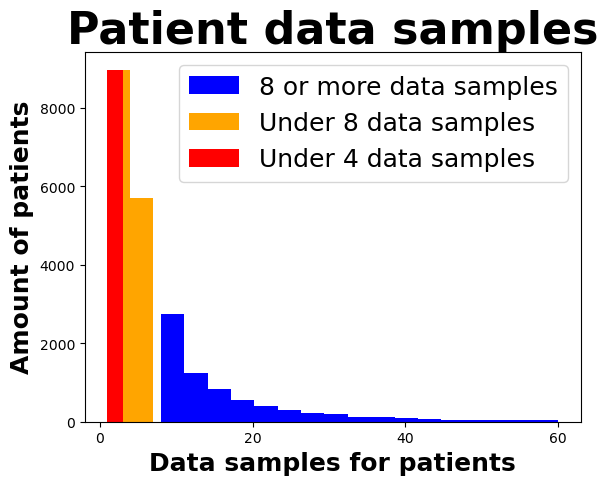

In [8]:
pat, count = np.unique(df_orig_no_dup.PatientID, return_counts=True)



print(f'Amount of patients: {len(np.unique(df_orig_no_dup.PatientID))}')
print(f'Amount less or equal than {MIN_LENGTH_OF_STAY}: {len(count[count < MIN_LENGTH_OF_STAY])}')
print(f'Amount more than {MIN_LENGTH_OF_STAY}: {len(count[count >= MIN_LENGTH_OF_STAY])}')
print(f'Amount more than {MAX_LENGTH_OF_STAY}: {len(count[count >= MAX_LENGTH_OF_STAY])}')


# Plotting the histogram
plt.hist(x=count[(count <= MAX_LENGTH_OF_STAY) & (count >= MIN_LENGTH_OF_STAY)], bins=int((MAX_LENGTH_OF_STAY-MIN_LENGTH_OF_STAY) / 3), color='blue', label=f'{MIN_LENGTH_OF_STAY} or more data samples')
plt.hist(x=count[count < MIN_LENGTH_OF_STAY], bins=int((MIN_LENGTH_OF_STAY) / 3), color='orange', label=f'Under {MIN_LENGTH_OF_STAY} data samples')
plt.hist(x=count[count < 4], bins=int((4) / 3), color='red', label=f'Under {4} data samples')

# Adding labels and title
plt.xlabel('Data samples for patients', fontsize=18, weight='bold')
plt.ylabel('Amount of patients', fontsize=18, weight='bold')
plt.title('Patient data samples', fontsize=32, weight='bold')
plt.rc('xtick', labelsize=26) 
plt.rc('ytick', labelsize=12) 
plt.legend(fontsize=18)

# Displaying the plot
plt.show()


### Long staying patients, check data collection interval.

Amount of patients with more than 60 datapoints in total: 31


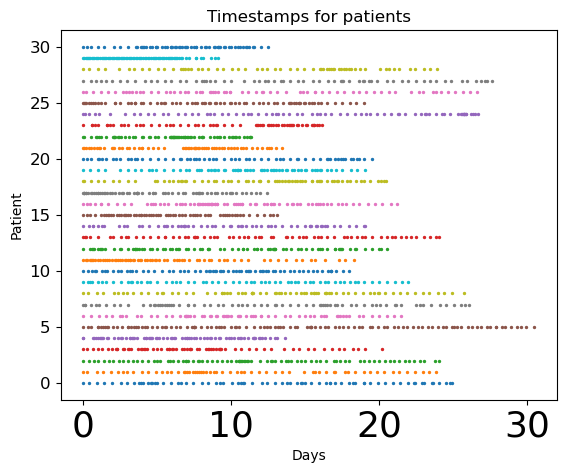

In [9]:
pat, count = np.unique(df_scrubb.PatientID, return_counts=True)
print(f'Amount of patients with more than {MAX_LENGTH_OF_STAY} datapoints in total: {len(count[count > MAX_LENGTH_OF_STAY])}')

df_long_stay = df_scrubb[np.isin(df_scrubb.PatientID, pat[count>MAX_LENGTH_OF_STAY])]


for i, patID in enumerate(df_long_stay.PatientID.unique()):
    df = df_long_stay[df_long_stay.PatientID==patID].copy()
    time_in = min(df.Timestamp)
    df.Timestamp = (df.Timestamp-time_in) /1000/3600/24
    num_data = len(df)

    y = np.ones(num_data)*i
    plt.scatter(df.Timestamp, y, s=2)

plt.xlabel('Days')
plt.ylabel('Patient')
plt.title('Timestamps for patients')
plt.show()

### check sample frequency

In [10]:
sample_frequency_list = []
low_freq_pat_list = []
high_freq_pat_list = []
low_sample_frequency_limit = 1
high_sample_frequency_limit = 24

no_time_patID = []

print(f'looping through {len(df_scrubb)} rows...')
for i, patID in tqdm(enumerate(df_scrubb.PatientID.unique())):
    df = df_scrubb[df_scrubb.PatientID==patID].copy()
    time_in = min(df.Timestamp)
    time_out = max(df.Timestamp)
    time_spent = (time_out - time_in )/ (1000 * 3600 * 24)
    if time_spent==0:
        no_time_patID.append(patID)
        continue  

    sample_frequency = len(df)/ time_spent

    if sample_frequency>high_sample_frequency_limit:
        high_freq_pat_list.append((patID, sample_frequency))
    elif sample_frequency<low_sample_frequency_limit:
        low_freq_pat_list.append((patID, sample_frequency))
    
    sample_frequency_list.append(sample_frequency)




looping through 115677 rows...


7822it [00:01, 4402.73it/s]


Number of patients checked: 7822
Number of patients with no change in Timestamp: 0
Number of patients with sample frequency over 24: 0
Number of patients with sample frequency under 1: 1


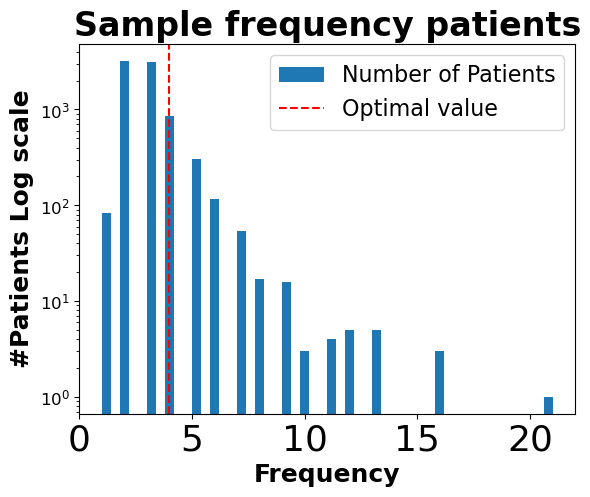

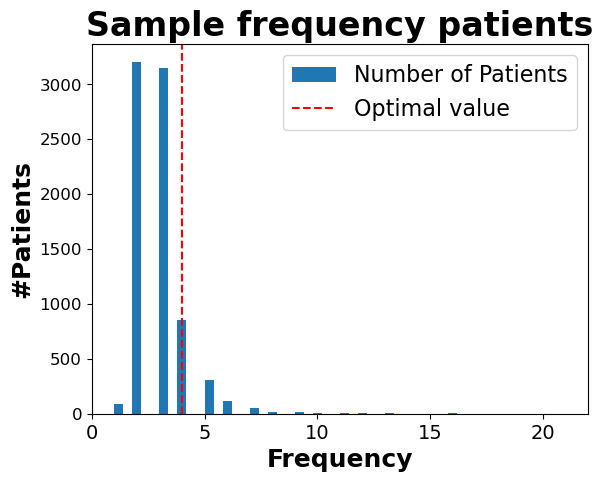

In [11]:
print(f'Number of patients checked: {len(df_scrubb.PatientID.unique())}')
print(f'Number of patients with no change in Timestamp: {len(no_time_patID)}')
print(f'Number of patients with sample frequency over {high_sample_frequency_limit}: {len(high_freq_pat_list)}')
print(f'Number of patients with sample frequency under {low_sample_frequency_limit}: {len(low_freq_pat_list)}')


_ = plt.hist(np.round(sample_frequency_list, 0), bins=50, log=True, label='Number of Patients')
# Add vertical line
vline_value = 4  # Value at which the vertical line should be placed
plt.axvline(x=vline_value, color='red', linestyle='--', label='Optimal value')

# Add labels and title
plt.xlabel('Frequency', fontsize=18, weight='bold')
plt.ylabel('#Patients Log scale', fontsize=18, weight='bold')
plt.title('Sample frequency patients', fontsize=24, weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=12) 
plt.legend(fontsize=16)
plt.show()

_ = plt.hist(np.round(sample_frequency_list, 0), bins=50, log=False, label='Number of Patients')
# Add vertical line
vline_value = 4  # Value at which the vertical line should be placed
plt.axvline(x=vline_value, color='red', linestyle='--', label='Optimal value')

# Add labels and title
plt.xlabel('Frequency', fontsize=18, weight='bold')
plt.ylabel('#Patients', fontsize=18, weight='bold')
plt.title('Sample frequency patients', fontsize=24, weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=12) 
plt.legend(fontsize=16)
plt.show()

# Missing data
### no missing data

In [50]:
np.sum(df_orig[df_orig.isna()], axis=0)

Index            0.0
PatientID        0.0
WardID           0.0
Timestamp        0.0
Systolic         0.0
Diastolic        0.0
O2               0.0
Pulse            0.0
Temp             0.0
Rf               0.0
Gender             0
Consciousness      0
AirOrO2            0
EwsScore         0.0
EwsType          0.0
WardName           0
dtype: object

In [51]:
df_scrubb

,Index,PatientID,WardID,Timestamp,Systolic,Diastolic,O2,Pulse,Temp,Rf,Gender,Consciousness,AirOrO2,EwsScore,EwsType,WardName,Time_in_care
10,10,12660707,2,1674705720000,120.0,66.0,94.0,113.0,39.5,28.0,None,Våken,Oksygen,10,1,Med enh. lunge-hem-kreft Bodø,94.385833
11,11,2639196,2,1674705834000,150.0,76.0,94.0,60.0,36.1,20.0,None,Våken,Luft,1,1,Med enh. lunge-hem-kreft Bodø,225.693889
15,15,12589700,2,1674706350000,113.0,55.0,90.0,82.0,36.1,16.0,F,Våken,Luft,3,1,Med enh. lunge-hem-kreft Bodø,745.720833
17,17,12644157,2,1674706607000,146.0,98.0,98.0,70.0,36.1,18.0,None,Våken,Luft,0,1,Med enh. lunge-hem-kreft Bodø,203.143889
18,18,12635003,2,1674706721000,189.0,98.0,92.0,68.0,36.1,14.0,None,Våken,Luft,2,1,Med enh. nyre-ford-inf Bodø,224.416111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369633,369633,2770753,3,1677278490000,99.0,52.0,90.0,92.0,38.2,28.0,None,Våken,Luft,10,1,Kir Gastro/Gyn/Brystendo Bodø,16.686389
369640,369640,2774474,3,1677281225000,120.0,70.0,92.0,89.0,36.4,18.0,None,Våken,Oksygen,4,1,Kirurgisk post Vesterålen,0.000000
369642,369642,2774180,3,1677282465000,85.0,50.0,94.0,58.0,36.9,17.0,None,Våken,Luft,4,1,Kirurgisk post Vesterålen,5.942222
369644,369644,2774118,3,1677287035000,128.0,62.0,93.0,99.0,36.6,20.0,None,Våken,Luft,3,1,Kir Gastro/Gyn/Brystendo Bodø,4.430556


In [52]:
if SAVE_DATA:
    df_scrubb.to_csv(SAVE_DATA_AS, index=False)